In [13]:
!pip install yfinance tensorflow

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
# Load Tesla (TSLA) data for a specific period
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2023-01-01'

In [4]:
# Fetch historical data for TSLA
tsla_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
# Show the first few rows of the data
print("First 5 rows of TSLA data:")
print(tsla_data.head())

First 5 rows of TSLA data:
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-01-02  14.858000  14.883333  14.217333  14.620667  14.620667  71466000
2015-01-05  14.303333  14.433333  13.810667  14.006000  14.006000  80527500
2015-01-06  14.004000  14.280000  13.614000  14.085333  14.085333  93928500
2015-01-07  14.223333  14.318667  13.985333  14.063333  14.063333  44526000
2015-01-08  14.187333  14.253333  14.000667  14.041333  14.041333  51637500


In [6]:
# Check for missing values
missing_values = tsla_data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [7]:
# Calculate daily returns and add as a new column
tsla_data['Daily Return'] = tsla_data['Adj Close'].pct_change()

In [8]:
# Explore basic statistics of daily returns
print("\nDescriptive statistics of TSLA daily returns:")
print(tsla_data['Daily Return'].describe())


Descriptive statistics of TSLA daily returns:
count    2013.000000
mean        0.001696
std         0.035731
min        -0.210628
25%        -0.015259
50%         0.001185
75%         0.018856
max         0.198949
Name: Daily Return, dtype: float64


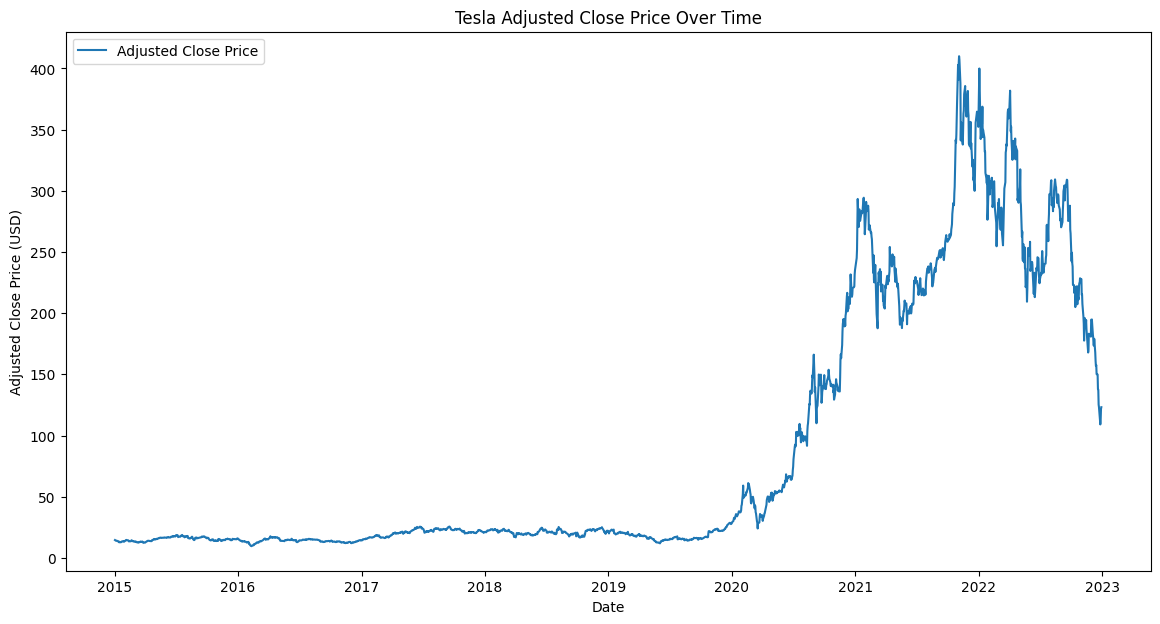

In [9]:
# Plot the adjusted closing price over time
plt.figure(figsize=(14, 7))
plt.plot(tsla_data['Adj Close'], label='Adjusted Close Price')
plt.title('Tesla Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.show()

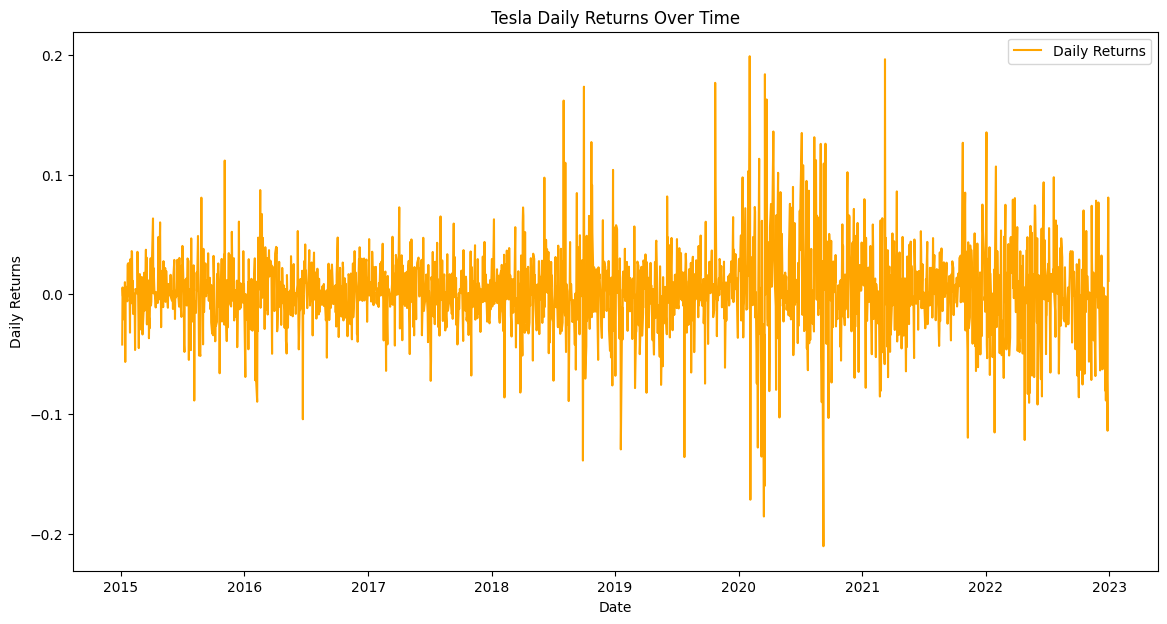

In [10]:
# Plot the daily returns over time
plt.figure(figsize=(14, 7))
plt.plot(tsla_data['Daily Return'], label='Daily Returns', color='orange')
plt.title('Tesla Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()

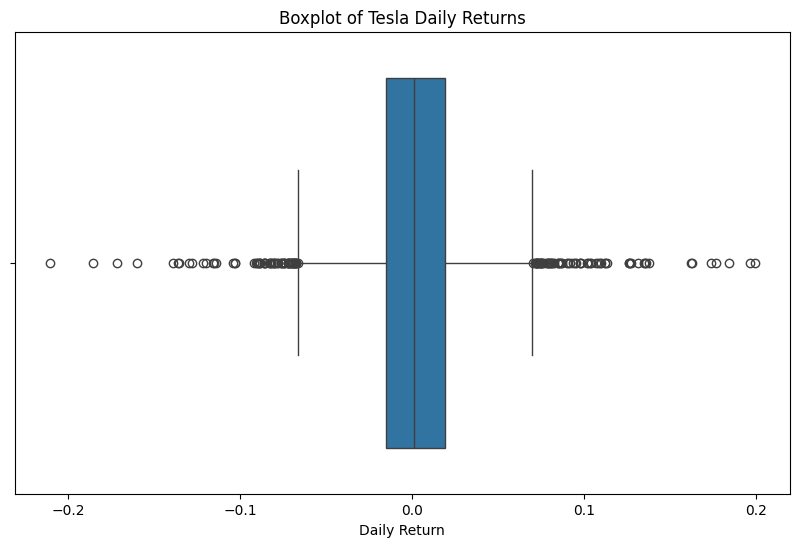

In [11]:
# Check for any outliers in daily returns using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=tsla_data['Daily Return'])
plt.title('Boxplot of Tesla Daily Returns')
plt.xlabel('Daily Return')
plt.show()

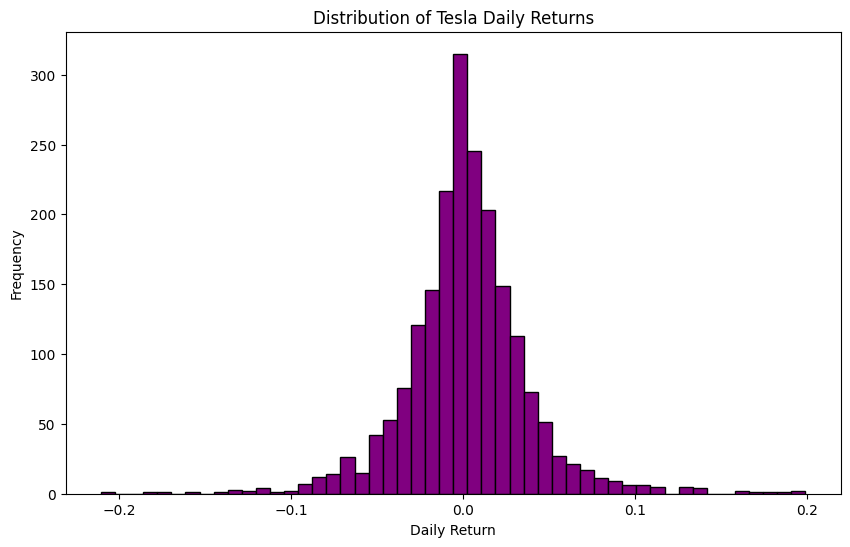

In [12]:
# Plot histogram of daily returns
plt.figure(figsize=(10, 6))
plt.hist(tsla_data['Daily Return'].dropna(), bins=50, color='purple', edgecolor='black')
plt.title('Distribution of Tesla Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

In [15]:
tsla_data = tsla_data[['Adj Close']]

In [18]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.6 MB/s eta 0:00:00


In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load Tesla data
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2023-01-01'
tsla_data = yf.download(ticker, start=start_date, end=end_date)
tsla_data = tsla_data[['Adj Close']]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
tsla_scaled = scaler.fit_transform(tsla_data)

# Create training and testing sets (80% train, 20% test)
train_size = int(len(tsla_scaled) * 0.8)
train_data, test_data = tsla_scaled[:train_size], tsla_scaled[train_size:]

[*********************100%***********************]  1 of 1 completed


In [20]:
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape inputs to (samples, time steps, features) for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(25),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
lstm_predictions = model.predict(X_test)
lstm_predictions_unscaled = scaler.inverse_transform(lstm_predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0110 - val_loss: 0.0055
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.8856e-04 - val_loss: 0.0040
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3967e-04 - val_loss: 0.0045
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7702e-04 - val_loss: 0.0039
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2048e-04 - val_loss: 0.0034
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0848e-04 - val_loss: 0.0030
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4463e-04 - val_loss: 0.0047
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4917e-04 - val_loss: 0.0028
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9936e-04 - val_loss: 0.0033
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7380e-04 - val_loss: 0.0040
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9056e-04 - val_loss: 0.0041
Epoch 12/20
49/49 ━━━━━━━━━━━━━

In [22]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare data for ARIMA by reversing the scale
train_arima = tsla_data.iloc[:train_size]['Adj Close']
test_arima = tsla_data.iloc[train_size:]['Adj Close']

# Find optimal (p, d, q) parameters with auto_arima
arima_model = auto_arima(train_arima, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the ARIMA model on training data
arima_model.fit(train_arima)

# Forecast on test set
arima_predictions = arima_model.predict(n_periods=len(test_arima))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8340.014, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8331.877, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8331.767, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8340.213, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8333.757, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8333.735, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8335.392, Time=2.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8332.366, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 5.513 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [23]:
# Calculate evaluation metrics for LSTM model
mae_lstm = mean_absolute_error(y_test_unscaled, lstm_predictions_unscaled)
rmse_lstm = np.sqrt(mean_squared_error(y_test_unscaled, lstm_predictions_unscaled))
mape_lstm = np.mean(np.abs((y_test_unscaled - lstm_predictions_unscaled) / y_test_unscaled)) * 100

print("LSTM Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_lstm}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lstm}")

# Calculate evaluation metrics for ARIMA model
mae_arima = mean_absolute_error(test_arima, arima_predictions)
rmse_arima = np.sqrt(mean_squared_error(test_arima, arima_predictions))
mape_arima = np.mean(np.abs((test_arima - arima_predictions) / test_arima)) * 100

print("\nARIMA Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_arima}")
print(f"Root Mean Squared Error (RMSE): {rmse_arima}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_arima}")

LSTM Model Performance:
Mean Absolute Error (MAE): 17.555960984257926
Root Mean Squared Error (RMSE): 22.37434532580193
Mean Absolute Percentage Error (MAPE): 6.120238470531439

ARIMA Model Performance:
Mean Absolute Error (MAE): 57.54098563999408
Root Mean Squared Error (RMSE): 73.67046339867156
Mean Absolute Percentage Error (MAPE): nan


<ipython-input-23-3952e9768590>:14: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape_arima = np.mean(np.abs((test_arima - arima_predictions) / test_arima)) * 100


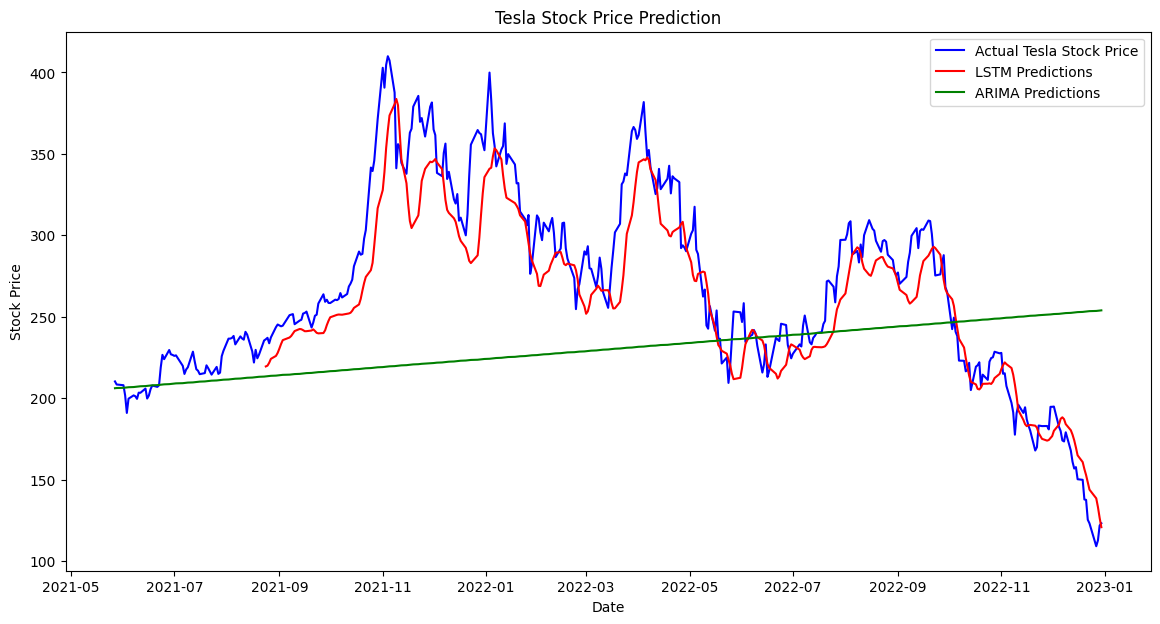

In [24]:
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(tsla_data.index[train_size:], test_arima, color='blue', label='Actual Tesla Stock Price')

# Plot LSTM predictions
plt.plot(tsla_data.index[train_size + time_step + 1:], lstm_predictions_unscaled, color='red', label='LSTM Predictions')

# Plot ARIMA predictions
plt.plot(tsla_data.index[train_size:], arima_predictions, color='green', label='ARIMA Predictions')

plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [25]:
# Generate 6-month (180 days) future predictions using the LSTM model
future_days = 180
lstm_future_predictions = []

last_sequence = X_test[-1]  # Start from the last sequence of the test data

for _ in range(future_days):
    next_pred = model.predict(last_sequence.reshape(1, time_step, 1))
    lstm_future_predictions.append(next_pred[0, 0])
    # Update the sequence by appending the predicted value and removing the first value
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(-1, 1)

# Inverse transform the predictions
lstm_future_predictions_unscaled = scaler.inverse_transform(np.array(lstm_future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [30]:
# Generate 6-month (180 days) forecast using the ARIMA model
arima_future_forecast, arima_conf_int = arima_model.predict(n_periods=future_days, return_conf_int=True)

# Convert forecast and confidence intervals to a DataFrame for visualization
future_dates = pd.date_range(tsla_data.index[-1], periods=future_days + 1, freq='B')[1:]
arima_forecast_df = pd.DataFrame({
    'Forecast': arima_future_forecast,
    'Lower CI': arima_conf_int[:, 0],
    'Upper CI': arima_conf_int[:, 1]
}, index=future_dates)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


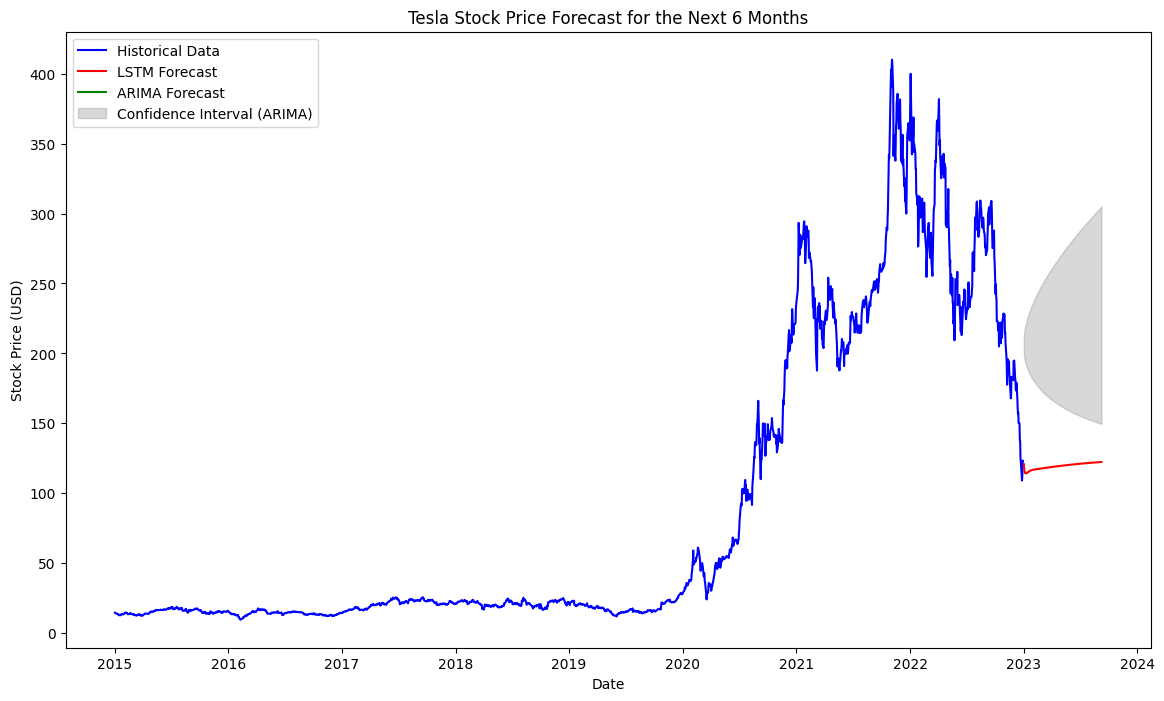

In [31]:
import matplotlib.pyplot as plt

# Plot historical data, LSTM predictions, and ARIMA forecast with confidence intervals
plt.figure(figsize=(14, 8))

# Historical data
plt.plot(tsla_data.index, tsla_data['Adj Close'], color='blue', label='Historical Data')

# Adjust future dates without using 'closed'
future_dates = pd.date_range(tsla_data.index[-1], periods=future_days + 1, freq='B')[1:]

# LSTM predictions
plt.plot(future_dates, lstm_future_predictions_unscaled, color='red', label='LSTM Forecast')

# ARIMA predictions and confidence intervals
plt.plot(arima_forecast_df.index, arima_forecast_df['Forecast'], color='green', label='ARIMA Forecast')
plt.fill_between(arima_forecast_df.index, arima_forecast_df['Lower CI'], arima_forecast_df['Upper CI'], color='gray', alpha=0.3, label='Confidence Interval (ARIMA)')

# Plot settings
plt.title('Tesla Stock Price Forecast for the Next 6 Months')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()